In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import math
from LucaM185 import BaseTransformer, train_model, plot_training_history, generate
device = torch.device("cuda:0")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [8]:
with open("datasets/enwik8", "r") as f:
    load = f.read()[:1000000]
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [9]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [10]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

997275


Millions of parameters: 7.23
step ___0 - Loss: 5.910 - Val Loss: 5.391
step _100 - Loss: 2.383 - Val Loss: 2.457
step _200 - Loss: 2.089 - Val Loss: 2.105
step _300 - Loss: 1.948 - Val Loss: 2.015
step _400 - Loss: 1.813 - Val Loss: 1.945
step _500 - Loss: 1.739 - Val Loss: 1.867
step _600 - Loss: 1.684 - Val Loss: 1.805
step _700 - Loss: 1.603 - Val Loss: 1.718
step _800 - Loss: 1.555 - Val Loss: 1.657
step _900 - Loss: 1.523 - Val Loss: 1.744


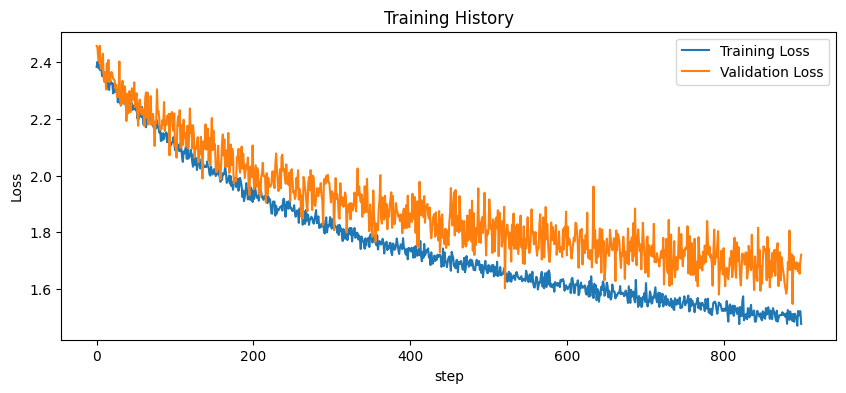

In [11]:

# Create model with default components (uses DefaultAttention and DefaultFullyConnected)
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_size=256,
    sequence_length=sequence_length,
    n_blocks=4
)

# Train it
history = train_model(
    model, inputs, labels, val_inputs, val_labels, vocab_size,
    steps=1000, batch_size=1024, device=device
)

# For inference with cached models:
model.reset_cache()  # Reset before inference
model.eval()

generate(model, '\n<mediawiki xmlns="http://www.media', sequence_length, device, texttoint, inttotext, num_tokens=300)

# Plot results
plot_training_history(history)


Millions of parameters: 21.92
step ___0 - Loss: 6.031 - Val Loss: 4.720
step _100 - Loss: 2.281 - Val Loss: 2.322
step _200 - Loss: 1.970 - Val Loss: 2.069
step _300 - Loss: 1.754 - Val Loss: 1.836
step _400 - Loss: 1.679 - Val Loss: 1.765
step _500 - Loss: 1.569 - Val Loss: 1.723
step _600 - Loss: 1.535 - Val Loss: 1.750
step _700 - Loss: 1.476 - Val Loss: 1.715
step _800 - Loss: 1.445 - Val Loss: 1.620
step _900 - Loss: 1.414 - Val Loss: 1.658


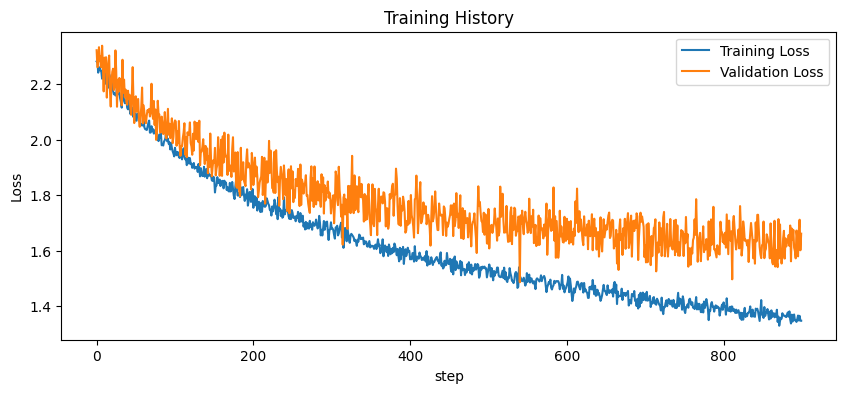

In [16]:

class DeeperFC(nn.Module):
    def __init__(self, emb_size, hidden_size, out_size, n_layers=6):
        super().__init__()
        hidden_size = emb_size * 8
        self.fc1 = nn.Linear(emb_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) 
        x = self.fc2(x)
        return x


# Create model with default components (uses DefaultAttention and DefaultFullyConnected)
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_size=256,
    sequence_length=sequence_length,
    n_blocks=4,
    fc_class=DeeperFC
)

# Train it
history = train_model(
    model, inputs, labels, val_inputs, val_labels, vocab_size,
    steps=1000, batch_size=1024, device=device
)

# For inference with cached models:
model.reset_cache()  # Reset before inference
model.eval()

generate(model, '\n<mediawiki xmlns="http://www.media', sequence_length, device, texttoint, inttotext, num_tokens=300)

# Plot results
plot_training_history(history)


In [37]:
class MLP(nn.Module):   
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x

class MoE(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers, out_size, n_experts, multiplier=4, topk=4):
        super().__init__()
        assert emb_size % topk == 0, "emb_size must be divisible by topk"

        self.fc1 = nn.Linear(emb_size, emb_size * multiplier)
        self.router = nn.Linear(emb_size, n_experts)
        self.experts = nn.ModuleList([MLP(emb_size * multiplier, emb_size//topk, emb_size, n_layers) for _ in range(n_experts)])
        self.topk = topk

    def forward(self, x):
        print(x.shape)
        # find topk experts
        router_logits = self.router(x)
        print(router_logits.shape)
        router_probs = F.softmax(router_logits, dim=-1)
        print(router_probs.shape)
        topk_values, topk_indices = torch.topk(router_probs, self.topk, dim=-1)
        print(topk_indices.shape)
        topk_values = topk_values.view(-1, self.topk)
        topk_indices = topk_indices.view(-1, self.topk)
        print(topk_indices)

        # gather expert outputs
        expert_outputs = []
        for i in range(self.topk):
            expert_outputs.append(self.experts[topk_indices[:, i]](x))
        expert_outputs = torch.stack(expert_outputs, dim=-1)
        print(expert_outputs.shape)

        # combine expert outputs
        return expert_outputs

# Create model with default components (uses DefaultAttention and DefaultFullyConnected)
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_size=256,
    sequence_length=sequence_length,
    n_blocks=4,
    fc_class=MoE,
    fc_kwargs={"n_experts": 8, "topk": 2}
)

# Train it
history = train_model(
    model, inputs, labels, val_inputs, val_labels, vocab_size,
    steps=1000, batch_size=1024, device=device
)

# For inference with cached models:
model.reset_cache()  # Reset before inference
model.eval()

generate(model, '\n<mediawiki xmlns="http://www.media', sequence_length, device, texttoint, inttotext, num_tokens=300)

# Plot results
plot_training_history(history)



Millions of parameters: 13.55
torch.Size([1024, 20, 256])
torch.Size([1024, 20, 8])
torch.Size([1024, 20, 8])
torch.Size([1024, 20, 2])
tensor([[7, 1],
        [7, 3],
        [5, 1],
        ...,
        [1, 2],
        [5, 1],
        [1, 3]], device='cuda:0')


TypeError: only integer tensors of a single element can be converted to an index